# TFG Tomás Camero

En este fichero de investigacíon, se pretende trabajar y experimentación con modelos de aprendizaje automáticos cuánticos, a la vez que se compara con los clásicos. Para ello, se ha realizado una clasificación multiclase de tres números del conjunto de datos MNIST, del cual se han elegido el 3, 4 y 5. El motivo de esta eleccion de solo tres números no es mas que debido a los tiempos de entrenamiento y la poca experiencia en este sector. A continuación se presenta un indice con cada modelo.

Para probar cada modelo, antes de redirigirse con el índice, es necesario ejecutar los imports globales y las variables globales. Después de eso, solo es ejecutar paso a paso cada modelo, desde el inicio hasta el final. 

IMPORTANTE: Debido a diferencias entre Qiskit y TensorFlow Quantum en los imports, es posible que si ejecutas Qiskit primero y luego intentas ejecutar TFQ, de problemas. Para solucionar esto, solo tienes que volver a ejecutar los imports globales y ejecutar TFQ de nuevo. 

* [MLP](#MLP)
    * [Inicialización de variables](#Inicialización)
    * [Búsqueda de hiperparámetros](#Búsqueda)
    * [Entrenamiento](#Entrenamiento)
    * [Resultados](#Resultados)
    * [Algunas gráficas](#Gráficas)
* [Keras](#Keras)
    * [Inicialización de variables](#Inicialización2)
    * [Creación del modelo](#Modelo2)
    * [Entrenamiento](#Entrenamiento2)
    * [Resultados](#Resultados2)
* [TensorFlow Quantum](#TensorFlow)
    * [Inicialización de variables](#Inicialización3)
    * [Clases](#Clases)
    * [Creación del modelo híbrido](#Modelo3)
    * [Entrenamiento](#Entrenamiento3)
    * [Resultados](#Resultados3)
* [Qiskit](#qiskit)
    * [Inicialización de variables](#Inicialización4)
    * [Funciones necesarias](#Funciones4)
    * [Creación de la red híbrido](#Modelo4)
    * [Entrenamiento](#Entrenamiento4)
    * [Resultados](#Resultados4)
* [Comparaciones](#comparaciones)

# Imports Globales

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib.patches import Wedge, Circle
%matplotlib inline
import numpy as np
import pandas as pd 
import time as time
import seaborn
import cProfile
from io import StringIO
import pstats
import psutil
import threading
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
import os
import random
from keras.datasets import mnist
from sklearn import metrics
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Variables Globales

In [2]:
cores = psutil.cpu_count()
init_notebook_mode(connected=True)
random_seed = 122230
#random_seed = random.randint(1,1000000)
#print(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
num_epochs = 20 
batch_size = 16 
num_classes = 3

# MLP<a class="anchor" id="MLP"></a>

In [3]:
from sklearn import datasets, metrics
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

## 1. Inicialización de variables <a class="anchor" id="Inicialización"></a>

In [4]:
cpu_percent_list_train_mlp = []
memory_usage_list_train_mlp= []
cpu_percent_list_test_mlp= []
memory_usage_list_test_mlp= []

In [5]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x.reshape(60000, 784)
test_x = test_x.reshape(10000, 784)

indices_train = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[indices_train]
y_train_filtered = train_y[indices_train]


indices_test = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[indices_test]
y_test_filtered = test_y[indices_test]


train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [6]:
def lists_cpu_and_ram_mlp_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_mlp.append(currentProcess.memory_percent())
        
def start_mlp_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_mlp_train)
    t.start()

def stop_mlp_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [7]:
def lists_cpu_and_ram_mlp_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_mlp.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_mlp.append(currentProcess.memory_percent())
        
def start_mlp_test():
    global t
    t = threading.Thread(target=lists_cpu_and_ram_mlp_test)
    t.start()

def stop_mlp_test():
    global running
    global t
    running = False

    t.join()

## 2. Funcion para buscar los mejores hiperparámetros <a class="anchor" id="Búsqueda"></a>

In [8]:
def busqueda_de_atributos_mlp(modelo):
    scoring = 'accuracy'
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (50, 100), (100, 50), 
                               (50, 50, 50), (100, 100, 100), (50, 100, 50), (100, 50, 100),
                               (50, 100, 50, 100), (100, 50, 100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [15000,20000,25000]
    }
    
    grid_search_mlp = HalvingGridSearchCV(estimator=modelo, param_grid=param_grid, scoring=scoring, cv=10)
    grid_search_mlp.fit(train_x, train_y)

    return [grid_search_mlp.best_estimator_,grid_search_mlp.best_params_]

## 3. Entrenamiento <a class="anchor" id="Entrenamiento"></a>

In [9]:
def entrenamientoyresultados_mlp(modelo):
    
    clf_mlp = modelo
    #Empezamos a contar el tiempo de entrenamiento
    startTrainingTime_mlp = time.time()
    
    # Entrenamiento
    start_mlp_train()
    try:
        clf_mlp.fit(train_x, train_y)
    finally:
        stop_mlp_train()


    #Terminamos de contar el tiempo de entrenamiento
    endTrainingTime_mlp = time.time()

    #Calculamos el tiempo de entrenamiento
    trainingTime_mlp = endTrainingTime_mlp - startTrainingTime_mlp  

    validResults_mlp = 0

    #Empezamos a contar el tiempo de testeo
    
    startTestingTime_mlp = time.time()
    
    start_mlp_test()
    try:
        
        predicted_mlp = clf_mlp.predict(test_x)
        precision_mlp = metrics.accuracy_score(test_y, predicted_mlp)
        
    finally:
        stop_mlp_test()
    
    #Terminamos de contar el tiempo de testeo
    endTestingTime_mlp = time.time()

    #Calculamos el tiempo de testeo
    testingTime_mlp = endTestingTime_mlp - startTestingTime_mlp  # Calculation of testing time
    
    #precision_mlp = round((validResults_mlp / testingSamples) * 100, 2)
    
    return precision_mlp*100,trainingTime_mlp, testingTime_mlp,clf_mlp,predicted_mlp

## 4. Resultados <a class="anchor" id="Resultados2"></a>

In [10]:
#parametros_mlp = busqueda_de_atributos_mlp(MLPClassifier())

In [11]:
#print(parametros_mlp[0])

In [12]:
#print(parametros_mlp[1])

In [13]:
modelo_mlp = MLPClassifier(activation='identity', alpha=0.001, hidden_layer_sizes=(100,), learning_rate='constant', max_iter=25000, solver='adam')
resultados_mlp = entrenamientoyresultados_mlp(modelo_mlp)

In [14]:
#print("Resultados con parametros: " + str(modelo[1]))
print("-------------------------------")
#print("Muestras de entrenamiento: ", trainingSamples)
print("Tiempo de entrenamiento: ", round(resultados_mlp[1], 2), " s")
#print("Muestras de testeo: ", testingSamples)
print("Tiempo de testeo: ", round(resultados_mlp[2], 2), " s")
print("Precisión: ", resultados_mlp[0], "%")
print("-------------------------------")
print("Uso de CPU en entrenamiento: ", cpu_percent_list_train_mlp)
print("-------------------------------")
print("Uso de CPU en test: ", cpu_percent_list_test_mlp)
print("-------------------------------")
print("Uso de RAM en entrenamiento: ", memory_usage_list_train_mlp)
print("-------------------------------")
print("Uso de RAM en test: ", memory_usage_list_test_mlp)

-------------------------------
Tiempo de entrenamiento:  31.04  s
Tiempo de testeo:  1.0  s
Precisión:  69.24410540915396 %
-------------------------------
Uso de CPU en entrenamiento:  [99.05833333333334, 99.80833333333334, 99.89166666666667, 99.89166666666667, 98.30833333333334, 99.71666666666665, 99.97500000000001, 99.96666666666665, 99.30833333333334, 99.98333333333333, 99.89166666666667, 100.13333333333333, 99.88333333333333, 99.97500000000001, 99.63333333333333, 99.72500000000001, 99.47500000000001, 99.96666666666665, 99.98333333333333, 100.05, 99.88333333333333, 99.96666666666665, 99.80833333333334, 99.96666666666665, 99.98333333333333, 99.96666666666665, 99.88333333333333, 99.97500000000001, 99.88333333333333, 99.88333333333333, 88.56666666666666]
-------------------------------
Uso de CPU en test:  [11.225]
-------------------------------
Uso de RAM en entrenamiento:  [2.74925232686139, 2.74925232686139, 2.74925232686139, 2.74925232686139, 2.74925232686139, 2.74925232686139, 

## 5. Algunas gráficas <a class="anchor" id="Gráficas"></a>

In [15]:
predicion_mlp = resultados_mlp[4]

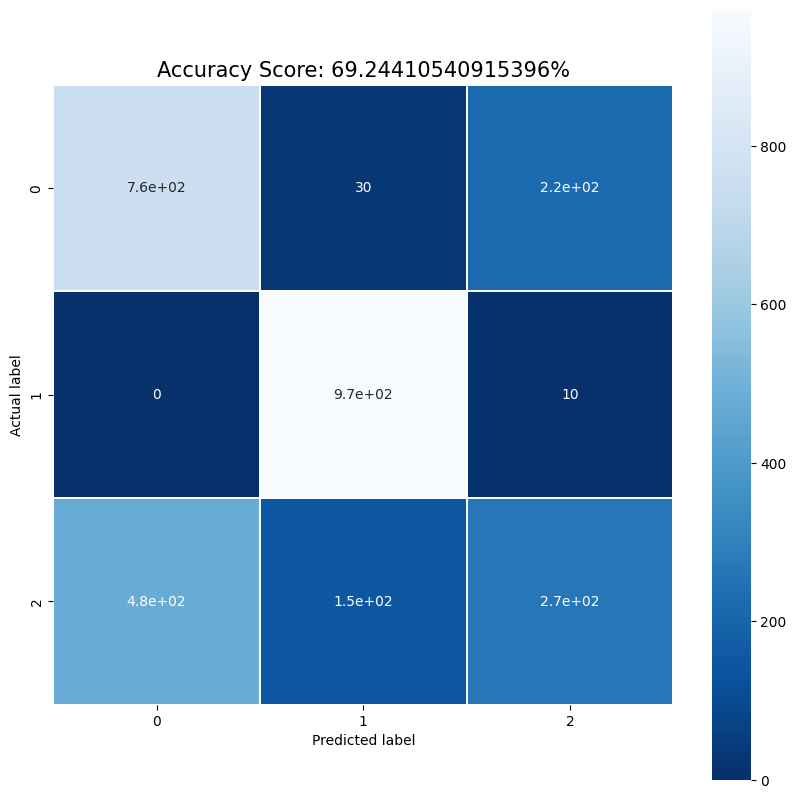

In [16]:
cm = metrics.confusion_matrix(test_y, predicion_mlp)
plt.figure(figsize=(10,10))
seaborn.heatmap(cm, annot=True, linewidths=.25, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}%'.format(resultados_mlp[0])
plt.title(all_sample_title, size = 15);

# Keras CNN<a class="anchor" id="Keras"></a>

In [17]:
from tensorflow.keras.datasets import mnist
import torch.nn.functional as F
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Dropout
import tensorflow as tf

## 1.  Inicialización de variables <a class="anchor" id="Inicialización2"></a>

In [18]:
cpu_percent_list_train_keras = []
memory_usage_list_train_keras = []
cpu_percent_list_test_keras = []
memory_usage_list_test_keras = []
cpu_percent_list_train_keras2 = []
memory_usage_list_train_keras2 = []
cpu_percent_list_test_keras2 = []
memory_usage_list_test_keras2 = []
tf.random.set_seed(random_seed)

In [19]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

In [20]:
def lists_cpu_and_ram_keras_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_keras.append(currentProcess.memory_percent())
        
def start_keras_train():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_train)
    t.start()

def stop_keras_train():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_keras.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_keras.append(currentProcess.memory_percent())
        
def start_keras_test():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_test)
    t.start()

def stop_keras_test():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_train2():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_keras2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_keras2.append(currentProcess.memory_percent())
        
def start_keras_train2():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_keras_train2)
    t.start()

def stop_keras_train2():
    global running
    global t

    running = False

    t.join()
    
def lists_cpu_and_ram_keras_test2():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_keras2.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_keras2.append(currentProcess.memory_percent())
        
def start_keras_test2():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_keras_test2)
    t.start()

def stop_keras_test2():
    global running
    global t

    running = False

    t.join()

In [21]:
train_indices = np.where((train_y == 3) | (train_y == 4) | (train_y == 5))
x_train_filtered = train_x[train_indices]
y_train_filtered = train_y[train_indices]
test_indices = np.where((test_y == 3) | (test_y == 4) | (test_y == 5))
x_test_filtered = test_x[test_indices]
y_test_filtered = test_y[test_indices]

y_train_filtered[y_train_filtered == 3] = 0
y_train_filtered[y_train_filtered == 4] = 1
y_train_filtered[y_train_filtered == 5] = 2
y_test_filtered[y_test_filtered == 3] = 0
y_test_filtered[y_test_filtered == 4] = 1
y_test_filtered[y_test_filtered == 5] = 2

train_y = y_train_filtered
test_y = y_test_filtered

train_x = np.array([resize(image, (4, 4)) for image in x_train_filtered])
test_x = np.array([resize(image, (4, 4)) for image in x_test_filtered])

train_x = np.expand_dims(train_x, axis=3)
test_x = np.expand_dims(test_x, axis=3)

train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x /= 255
test_x /= 255

In [22]:
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

## 2. Creacion de modelos <a class="anchor" id="Modelo2"></a>

In [23]:
model_keras = Sequential()
model_keras.add(Conv2D(input_shape=(4, 4, 1), filters=32, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=64, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Conv2D(filters=128, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras.add(Flatten())
model_keras.add(Dense(128, activation='relu'))
model_keras.add(Dropout(0.5))
model_keras.add(BatchNormalization())
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))

In [24]:
model_keras2 = Sequential()
model_keras2.add(Conv2D(input_shape=(4, 4, 1), filters=32, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Conv2D(filters=64, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Conv2D(filters=128, strides=(2, 2), padding='same', activation='relu', kernel_size=(3, 3)))
model_keras2.add(Flatten())
model_keras2.add(Dense(128, activation='relu'))
model_keras2.add(Dropout(0.5))
model_keras2.add(BatchNormalization())
model_keras2.add(Dense(32, activation='relu'))
model_keras2.add(Dense(3, activation='softmax'))

## 3. Entrenamiento <a class="anchor" id="Entrenamiento2"></a>

In [25]:
adam = Adam(learning_rate=0.0001) # ajustar la tasa de aprendizaje
batch_size2 = 32
model_keras.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
start_keras_train()
startTrainingTime_keras = time.time()
history_keras = model_keras.fit(train_x, train_y, batch_size=batch_size2, epochs=num_epochs, validation_split=0.1)
stop_keras_train()
stopTrainingTime_keras = time.time()
endTrainingTime_keras = stopTrainingTime_keras - startTrainingTime_keras 

Epoch 1/20
490/490 [==============================] - 2s 2ms/step - loss: 1.0982 - accuracy: 0.3470 - val_loss: 1.0976 - val_accuracy: 0.3517
Epoch 2/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0976 - accuracy: 0.3489 - val_loss: 1.0975 - val_accuracy: 0.3517
Epoch 3/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0978 - accuracy: 0.3524 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 4/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0975 - accuracy: 0.3542 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 5/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0975 - accuracy: 0.3508 - val_loss: 1.0973 - val_accuracy: 0.4931
Epoch 6/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0974 - accuracy: 0.3535 - val_loss: 1.0967 - val_accuracy: 0.3517
Epoch 7/20
490/490 [==============================] - 1s 2ms/step - loss: 1.0810 - accuracy: 0.4310 - val_loss: 0.9872 - val_accuracy: 0.5902
Epoch 

In [26]:
adam = Adam(learning_rate=0.0001) # ajustar la tasa de aprendizaje
model_keras2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
start_keras_train2()
startTrainingTime_keras2 = time.time()
history_keras2 = model_keras2.fit(train_x, train_y, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
stop_keras_train2()
stopTrainingTime_keras2 = time.time()
endTrainingTime_keras2 = stopTrainingTime_keras2 - startTrainingTime_keras2 

Epoch 1/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0979 - accuracy: 0.3462 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 2/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0979 - accuracy: 0.3515 - val_loss: 1.0975 - val_accuracy: 0.3517
Epoch 3/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3486 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 4/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3525 - val_loss: 1.0973 - val_accuracy: 0.3517
Epoch 5/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3526 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 6/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0976 - accuracy: 0.3512 - val_loss: 1.0972 - val_accuracy: 0.3517
Epoch 7/20
979/979 [==============================] - 2s 2ms/step - loss: 1.0977 - accuracy: 0.3510 - val_loss: 1.0974 - val_accuracy: 0.3517
Epoch 

## 4. Resultados <a class="anchor" id="Resultados"></a>

In [27]:
start_keras_test()
starTestingTime_keras = time.time()
score = model_keras.evaluate(test_x, test_y, verbose=0)
stop_keras_test()
stopTestingTime_keras = time.time()
endTestingTime_keras = stopTestingTime_keras - starTestingTime_keras
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5136867761611938
Test accuracy: 0.7732316255569458


In [28]:
start_keras_test2()
starTestingTime_keras2 = time.time()
score2 = model_keras2.evaluate(test_x, test_y, verbose=0)
stop_keras_test2()
stopTestingTime_keras2 = time.time()
endTestingTime_keras2 = stopTestingTime_keras2 - starTestingTime_keras2
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 0.5980391502380371
Test accuracy: 0.6903606057167053


# TensorFlow Quantum <a class="anchor" id="TensorFlow"></a>

In [29]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,BatchNormalization,Dropout
import tensorflow_quantum as tfq
import cirq
import sympy

## 1.  Inicialización de variables <a class="anchor" id="Inicialización3"></a>

In [30]:
cpu_percent_list_train_tfq = []
memory_usage_list_train_tfq= []
cpu_percent_list_test_tfq= []
memory_usage_list_test_tfq= []
tf.random.set_seed(random_seed)
num_quantum_layers = 5  
dense_layer_sizes = [64, 32] 
learning_rate = 0.0001  
dropout_rate = 0.4  
l1_reg = 0 
l2_reg = 0  

In [31]:
def lists_cpu_and_ram_tfq_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_tfq.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_tfq.append(currentProcess.memory_percent())
        
def start_tfq_train():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_train)
    t.start()

def stop_tfq_train():
    global running
    global t

    running = False

    t.join()

In [32]:
def lists_cpu_and_ram_tfq_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_tfq.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_tfq.append(currentProcess.memory_percent())
        
def start_tfq_test():
    global t

    t = threading.Thread(target=lists_cpu_and_ram_tfq_test)
    t.start()

def stop_tfq_test():
    global running
    global t

    running = False

    t.join()

In [33]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

train_filter = np.where((y_train == 3) | (y_train == 4) | (y_train == 5))
test_filter = np.where((y_test == 3) | (y_test == 4) | (y_test == 5))
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [34]:
def map_labels(y):
    label_mapping = {3: 0, 4: 1, 5: 2}
    return np.array([label_mapping[label] for label in y])

In [35]:
y_train_mapped = map_labels(y_train)
y_test_mapped = map_labels(y_test)

y_train = to_categorical(y_train_mapped, num_classes)
y_test = to_categorical(y_test_mapped, num_classes)

# Asegurar que el tamaño del conjunto de entrenamiento sea divisible por batch_size
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
num_train_batches = len(x_train) // batch_size
num_val_batches = len(x_val) // batch_size

x_train = x_train[:num_train_batches * batch_size]
y_train = y_train[:num_train_batches * batch_size]

x_val = x_val[:num_val_batches * batch_size]
y_val = y_val[:num_val_batches * batch_size]

In [36]:
def downsample(image, size=(4, 4)):
    return tf.image.resize(image, size)

In [37]:
qubits = cirq.GridQubit.rect(4, 4)
readout_operators = [cirq.Z(qubits[-1])]

## 2. Clases necesarias <a class="anchor" id="Clases"></a>

In [38]:
def generate_data_circuit(x):
    circuit = cirq.Circuit()
    qubits = cirq.GridQubit.rect(4, 4)
    
    for i, pixel in enumerate(x.flatten()):
        if pixel:
            circuit.append(cirq.ry(np.pi * pixel).on(qubits[i]))
            circuit.append(cirq.rz(np.pi * pixel).on(qubits[i]))
    
    return circuit

In [39]:
x_train_downsampled = np.array([downsample(x) for x in x_train])
x_val_downsampled = np.array([downsample(x) for x in x_val])
x_test_downsampled = np.array([downsample(x) for x in x_test])

x_train_circuits = [generate_data_circuit(x) for x in x_train_downsampled]
x_val_circuits = [generate_data_circuit(x) for x in x_val_downsampled]
x_test_circuits = [generate_data_circuit(x) for x in x_test_downsampled]

x_train_tfcirc = tfq.convert_to_tensor(x_train_circuits)
x_val_tfcirc = tfq.convert_to_tensor(x_val_circuits)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits)

# Asegurar que el tamaño del conjunto de prueba sea divisible por batch_size
num_test_batches = len(x_test) // batch_size
x_test_downsampled = x_test_downsampled[:num_test_batches * batch_size]
x_test = x_test[:num_test_batches * batch_size]
y_test = y_test[:num_test_batches * batch_size]

x_test_tfcirc = tfq.convert_to_tensor(x_test_circuits[:num_test_batches * batch_size])

In [40]:
def generate_model_circuit(qubits, num_layers):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols(f"theta(0:{16 * num_layers})")

    for layer in range(num_layers):
        for i in range(0, 16, 4):
            model_circuit += cirq.Circuit(
                cirq.rx(symbols[16 * layer + i]).on(qubits[i]),
                cirq.rz(symbols[16 * layer + i + 1]).on(qubits[i + 1]),
                cirq.rx(symbols[16 * layer + i + 2]).on(qubits[i + 2]),
                cirq.rz(symbols[16 * layer + i + 3]).on(qubits[i + 3]),
            )

            model_circuit += cirq.Circuit(
                cirq.CZ(qubits[i], qubits[i + 1]),
                cirq.CZ(qubits[i + 1], qubits[i + 2]),
                cirq.CZ(qubits[i + 2], qubits[i + 3]),
            )

        model_circuit += cirq.Circuit(
            cirq.CZ(qubits[0], qubits[3]),
            cirq.CZ(qubits[12], qubits[15]),
        )

    return model_circuit

## 3. Modelo Híbrido <a class="anchor" id="Modelo3"></a>

In [41]:
model_circuit = generate_model_circuit(qubits, num_quantum_layers)
quantum_model = tfq.layers.PQC(model_circuit, readout_operators)

In [42]:
# Entradas
dense_input = tf.keras.Input(shape=(4, 4, 1), name='dense_input')
quantum_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string, name='quantum_input', batch_size=batch_size)

# Circuito cuántico
flatten = Flatten()(dense_input)
dense_classic_1 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(flatten)
dense_classic_2 = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu)(dense_classic_1)
reshaped = tf.keras.layers.Reshape((4, 4, 1))(dense_classic_2)
downsampled = downsample(reshaped)

# Aplanar la salida de downsampled
flat_downsampled = Flatten()(downsampled)

# Red cuántica
quantum = quantum_model(quantum_input)

# Modelo híbrido
concat = tf.keras.layers.Concatenate()([flat_downsampled, quantum])
dense_1 = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(concat)
dense_2 = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu)(dense_1)
dropout = tf.keras.layers.Dropout(dropout_rate)(dense_2)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(dropout)

# Crea el modelo
model_tfq = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)

In [43]:
model_tfq = tf.keras.Model(inputs=[dense_input, quantum_input], outputs=outputs)
model_tfq.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

## 4. Entrenamiento  <a class="anchor" id="Entrenamiento3"></a>

In [44]:
start_tfq_train()
startTrainingTime_tfq = time.time()
history_tfq = model_tfq.fit(
    [x_train_downsampled, x_train_tfcirc], y_train, 
    batch_size=batch_size, epochs=num_epochs, verbose=1, 
    validation_data=([x_val_downsampled, x_val_tfcirc], y_val)
)
stop_tfq_train()
stopTrainingTime_tfq = time.time()
endTrainingTime_tfq = stopTrainingTime_tfq - startTrainingTime_tfq

Epoch 1/20
869/869 [==============================] - 182s 209ms/step - loss: 1.0370 - accuracy: 0.4762 - val_loss: 0.9143 - val_accuracy: 0.6506
Epoch 2/20
869/869 [==============================] - 184s 211ms/step - loss: 0.8521 - accuracy: 0.6380 - val_loss: 0.7669 - val_accuracy: 0.6835
Epoch 3/20
869/869 [==============================] - 185s 212ms/step - loss: 0.7958 - accuracy: 0.6596 - val_loss: 0.7443 - val_accuracy: 0.6895
Epoch 4/20
869/869 [==============================] - 185s 213ms/step - loss: 0.7842 - accuracy: 0.6679 - val_loss: 0.7338 - val_accuracy: 0.6941
Epoch 5/20
869/869 [==============================] - 186s 214ms/step - loss: 0.7724 - accuracy: 0.6787 - val_loss: 0.7255 - val_accuracy: 0.6910
Epoch 6/20
869/869 [==============================] - 185s 213ms/step - loss: 0.7605 - accuracy: 0.6854 - val_loss: 0.7183 - val_accuracy: 0.6953
Epoch 7/20
869/869 [==============================] - 187s 215ms/step - loss: 0.7575 - accuracy: 0.6858 - val_loss: 0.7140 -

## 5. Resultados <a class="anchor" id="Resultados3"></a>

In [45]:
start_tfq_test()
startTestingTime_tfq = time.time()
test_loss, test_acc = model_tfq.evaluate([x_test_downsampled, x_test_tfcirc], y_test, batch_size=batch_size, verbose=1)
stop_tfq_test()
stopTestingTime_tfq = time.time()
endTestingTime_tfq = stopTestingTime_tfq - startTestingTime_tfq
print("Test accuracy:", test_acc)

180/180 [==============================] - 7s 39ms/step - loss: 0.6740 - accuracy: 0.7233
Test accuracy: 0.7232638597488403


# Qiskit <a class="anchor" id="qiskit"></a>

In [46]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZFeatureMap
from qiskit.opflow import Z, StateFn
from qiskit.utils import QuantumInstance

## 1.  Inicialización de variables <a class="anchor" id="Inicialización4"></a>

In [47]:
cpu_percent_list_train_q= []
memory_usage_list_train_q= []
cpu_percent_list_test_q= []
memory_usage_list_test_q= []
n_samples = None

def lists_cpu_and_ram_q_train():
    global running
    running = True

    currentProcess = psutil.Process()
    while running:
        cpu_percent_list_train_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_train_q.append(currentProcess.memory_percent())
        
def start_q_train():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_train)
    t.start()

def stop_q_train():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()
    
def lists_cpu_and_ram_q_test():
    global running
    running = True
    currentProcess = psutil.Process()

    while running:
        cpu_percent_list_test_q.append(currentProcess.cpu_percent(interval=1)/cores)
        memory_usage_list_test_q.append(currentProcess.memory_percent())
        
def start_q_test():
    global t

    # create thread and start it
    t = threading.Thread(target=lists_cpu_and_ram_q_test)
    t.start()

def stop_q_test():
    global running
    global t

    # use `running` to stop loop in thread so thread will end
    running = False

    # wait for thread's end
    t.join()

In [48]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx_3 = np.where(X_train.targets == 3)[0][:n_samples]
idx_6 = np.where(X_train.targets == 4)[0][:n_samples]
idx_9 = np.where(X_train.targets == 5)[0][:n_samples]
idx = np.concatenate((idx_3, idx_6, idx_9), axis=0)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]
X_train.targets[X_train.targets == 3] = 0
X_train.targets[X_train.targets == 4] = 1
X_train.targets[X_train.targets == 5] = 2

X_train.data = torch.nn.functional.interpolate(X_train.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_train.data = X_train.data/255.0

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [49]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idy_3 = np.where(X_test.targets == 3)[0][:n_samples]
idy_6 = np.where(X_test.targets == 4)[0][:n_samples]
idy_9 = np.where(X_test.targets == 5)[0][:n_samples]
idy = np.concatenate((idy_3, idy_6, idy_9), axis=0)

X_test.data = X_test.data[idy]
X_test.targets = X_test.targets[idy]
X_test.targets[X_test.targets == 3] = 0
X_test.targets[X_test.targets == 4] = 1
X_test.targets[X_test.targets == 5] = 2

X_test.data = torch.nn.functional.interpolate(X_test.data.unsqueeze(1).float(), size=(4,4)).squeeze()

X_test.data = X_test.data/255.0

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [50]:
X_train.data = X_train.data.float() / 255.0
y_train = X_train.targets

X_test.data = X_test.data.float() / 255.0
y_test = X_test.targets

## 2. Funciones necesarias <a class="anchor" id="Funciones4"></a>

In [51]:
class QuantumCircuit:
    
    def __init__(self, n_qubits, backend, shots):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots

    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds=[{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result_list = job.result().get_counts()

        # Combinar los resultados en un solo diccionario
        result = {}
        for r in result_list:
            for k, v in r.items():
                if k in result:
                    result[k] += v
                else:
                    result[k] = v

        counts = np.array(list(result.values()))
        states = np.array([int(k, 2) for k in result.keys()]).astype(float)
        probabilities = counts / (self.shots * len(thetas))
        expectation = np.sum(states * probabilities)

        return np.array([expectation])




In [52]:
class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z, dtype=torch.float32)
        
        ctx.save_for_backward(inputs, result)
        return result

        
    @staticmethod
    def backward(ctx, grad_output):
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = np.zeros_like(input_list)
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients[i] = gradient

        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(16, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)


## 3. Red Híbrida <a class="anchor" id="Modelo4"></a>

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, padding=0)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)  
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc4 = nn.Linear(1, 3) 


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.hybrid(x)  # Utiliza solo una capa cuántica en lugar de varias
        x = self.fc4(x)  # Agrega la capa lineal adicional después de la capa cuántica
        return x

## 4. Entrenamiento <a class="anchor" id="Entrenamiento4"></a>

In [54]:
model_q = Net()
optimizer = optim.Adam(model_q.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 20
loss_list = []

start_q_train()
startTrainingTime_q = time.time()
model_q.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
  
        output = model_q(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

stop_q_train()
stopTrainingTime_q = time.time()
endTrainingTime_q = stopTrainingTime_q - startTrainingTime_q

/tmp/ipykernel_3388234/1495654091.py:11: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)



Training [5%]	Loss: 220.4246
Training [10%]	Loss: 36.4730
Training [15%]	Loss: 27.1732
Training [20%]	Loss: 9.0200
Training [25%]	Loss: 1.2877
Training [30%]	Loss: 1.2625
Training [35%]	Loss: 1.2548
Training [40%]	Loss: 1.2462
Training [45%]	Loss: 1.2227
Training [50%]	Loss: 1.2210
Training [55%]	Loss: 1.1926
Training [60%]	Loss: 1.1523
Training [65%]	Loss: 1.1259
Training [70%]	Loss: 1.1143
Training [75%]	Loss: 1.1159
Training [80%]	Loss: 1.1154
Training [85%]	Loss: 1.1153
Training [90%]	Loss: 1.1155
Training [95%]	Loss: 1.1129
Training [100%]	Loss: 1.1100


## 5. Resultados <a class="anchor" id="Resultados4"></a>

In [55]:
model_q.eval()
start_q_test()
startTestingTime_q = time.time()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_q(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        accuracy = correct / len(test_loader) * 100 / batch_size
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100 / batch_size)
        )
    
stop_q_test()
stopTestingTime_q = time.time()
endTestingTime_q = stopTestingTime_q - startTestingTime_q

Performance on test data:
	Loss: 1.1096
	Accuracy: 31.7%


# Comparaciones <a class="anchor" id="comparaciones"></a>

In [56]:
list_classifiers = ['MLP','Keras','Keras2','TFQ','Qiskit']
val_scores = [resultados_mlp[0], score[1]*100,score2[1]*100,test_acc*100,accuracy]

In [57]:
trace1 = go.Scatter(x = list_classifiers, y = val_scores,
                   name="Validation", text = list_classifiers)

data = [trace1]

layout = dict(title = "Validation and Submission Scores", 
              xaxis=dict(ticklen=10, zeroline= False),
              yaxis=dict(title = "Accuracy", side='left', ticklen=10,),                                  
              legend=dict(orientation="v", x=1.05, y=1.0),
              autosize=False, width=750, height=500,
              )

fig = dict(data = data, layout = layout)
iplot(fig)

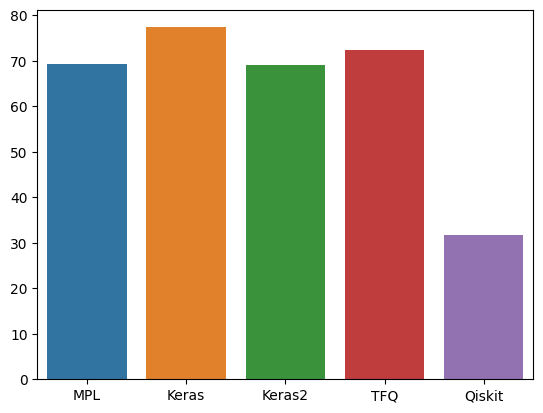

In [58]:
grafica_precision = seaborn.barplot(x=["MPL","Keras","Keras2","TFQ","Qiskit"],y=[resultados_mlp[0], score[1]*100,score2[1]*100,test_acc*100,accuracy])
grafica_precision.figure.savefig("Precision_modelos.png", dpi=400)

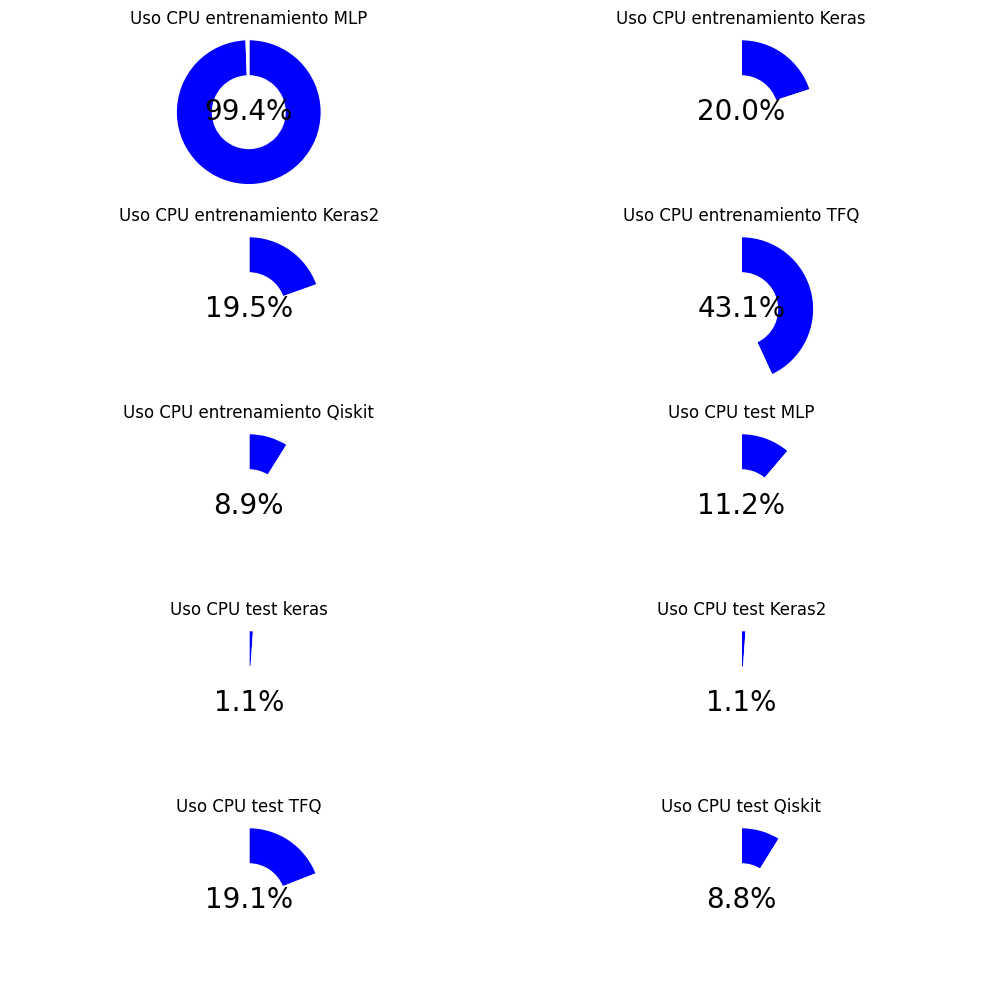

In [59]:
media_uso_cpu_entrenamiento_mlp = np.mean(cpu_percent_list_train_mlp)
media_uso_cpu_entrenamiento_keras = np.mean(cpu_percent_list_train_keras)
media_uso_cpu_entrenamiento_keras2 = np.mean(cpu_percent_list_train_keras2)
media_uso_cpu_entrenamiento_tfq = np.mean(cpu_percent_list_train_tfq)
media_uso_cpu_entrenamiento_q = np.mean(cpu_percent_list_train_q)

media_uso_cpu_test_mlp = np.mean(cpu_percent_list_test_mlp)
media_uso_cpu_test_keras = np.mean(cpu_percent_list_test_keras)
media_uso_cpu_test_keras2 = np.mean(cpu_percent_list_test_keras2)
media_uso_cpu_test_tfq = np.mean(cpu_percent_list_test_tfq)
media_uso_cpu_test_q = np.mean(cpu_percent_list_test_q)

nombres = ['Uso CPU entrenamiento MLP',
           'Uso CPU entrenamiento Keras',
           'Uso CPU entrenamiento Keras2',
           'Uso CPU entrenamiento TFQ',
           'Uso CPU entrenamiento Qiskit',
           'Uso CPU test MLP',
           'Uso CPU test keras',
           'Uso CPU test Keras2',
           'Uso CPU test TFQ',
           'Uso CPU test Qiskit']

porcentajes = [media_uso_cpu_entrenamiento_mlp,
               media_uso_cpu_entrenamiento_keras,
               media_uso_cpu_entrenamiento_keras2,
               media_uso_cpu_entrenamiento_tfq,
               media_uso_cpu_entrenamiento_q,
               media_uso_cpu_test_mlp,
               media_uso_cpu_test_keras,
               media_uso_cpu_test_keras2, 
               media_uso_cpu_test_tfq,
               media_uso_cpu_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')
    axs[row, col].set_title(nombre)

fig.tight_layout()
plt.savefig('Porcentajes_uso_cpu.png', dpi=400)
plt.show()

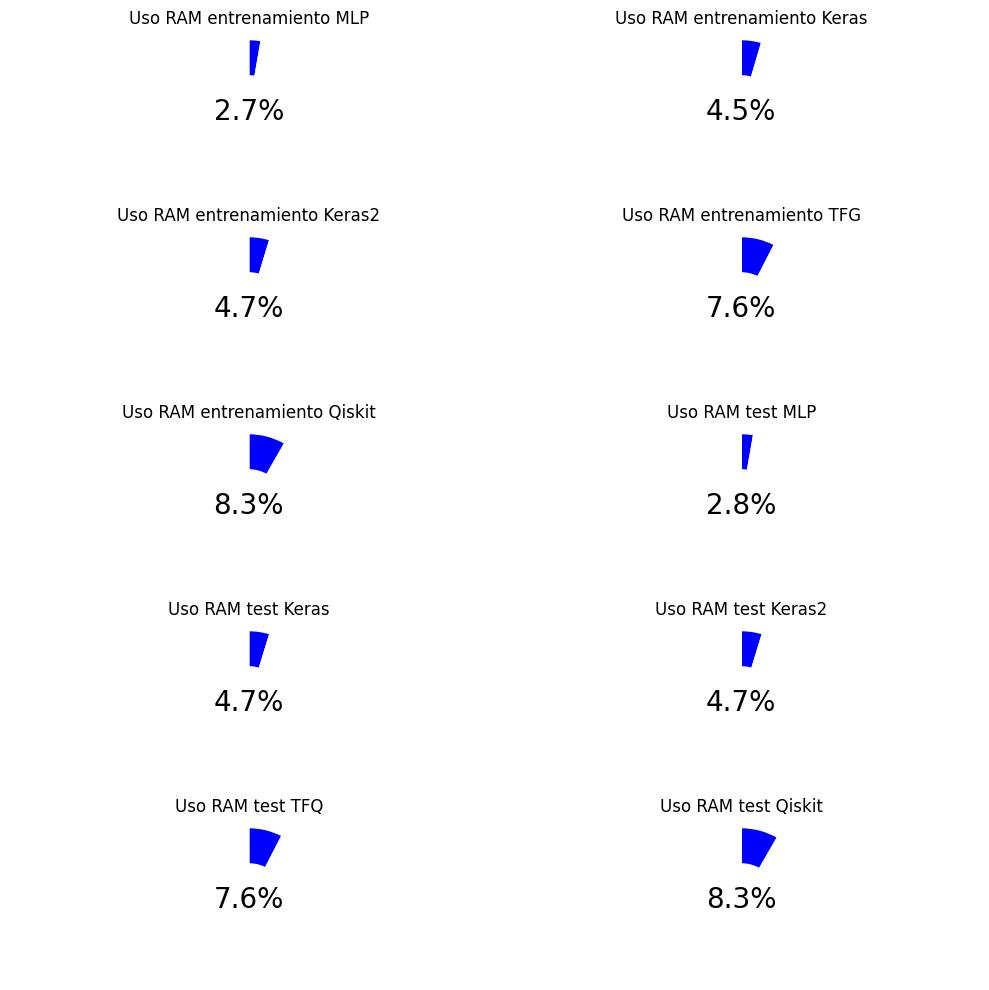

In [60]:
media_uso_ram_entrenamiento_mlp = np.mean(memory_usage_list_train_mlp)
media_uso_ram_entrenamiento_keras = np.mean(memory_usage_list_train_keras)
media_uso_ram_entrenamiento_keras2 = np.mean(memory_usage_list_train_keras2)
media_uso_ram_entrenamiento_tfq = np.mean(memory_usage_list_train_tfq)
media_uso_ram_entrenamiento_q = np.mean(memory_usage_list_train_q)

media_uso_ram_test_mlp = np.mean(memory_usage_list_test_mlp)
media_uso_ram_test_keras = np.mean(memory_usage_list_test_keras)
media_uso_ram_test_keras2 = np.mean(memory_usage_list_test_keras2)
media_uso_ram_test_tfq = np.mean(memory_usage_list_test_tfq)
media_uso_ram_test_q = np.mean(memory_usage_list_test_q)

nombres = ['Uso RAM entrenamiento MLP',
           'Uso RAM entrenamiento Keras',
           'Uso RAM entrenamiento Keras2',
           'Uso RAM entrenamiento TFG',
           'Uso RAM entrenamiento Qiskit',
           'Uso RAM test MLP',
           'Uso RAM test Keras',
           'Uso RAM test Keras2',
           'Uso RAM test TFQ',
           'Uso RAM test Qiskit']

porcentajes = [media_uso_ram_entrenamiento_mlp, 
               media_uso_ram_entrenamiento_keras,
               media_uso_ram_entrenamiento_keras2,
               media_uso_ram_entrenamiento_tfq,
               media_uso_ram_entrenamiento_q,
               media_uso_ram_test_mlp,
               media_uso_ram_test_keras,
               media_uso_ram_test_keras2, 
               media_uso_ram_test_tfq,
               media_uso_ram_test_q]


num_plots = len(porcentajes)
num_cols = min(num_plots, 2)
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i, (porcentaje, nombre) in enumerate(zip(porcentajes, nombres)):
    row = i // num_cols
    col = i % num_cols
    restante = 100 - porcentaje
    datos = [porcentaje, restante]
    axs[row, col].pie(datos, colors=['blue', 'white'], startangle=90, counterclock=False, wedgeprops={'width': 0.5, 'edgecolor': 'white'})
    axs[row, col].text(0, 0, f'{np.around(porcentaje, 1)}%', ha='center', va='center', fontsize=20)
    axs[row, col].axis('equal')

    axs[row, col].set_title(nombre)


fig.tight_layout()
plt.savefig('Porcentajes_uso_ram.png', dpi=400)
plt.show()

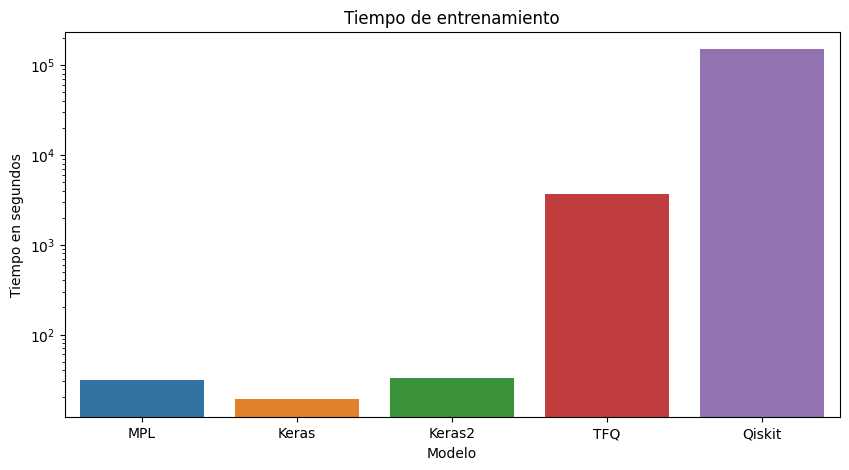

In [61]:
modelos = ["MPL", "Keras", "Keras2", "TFQ", "Qiskit"]
counts = [resultados_mlp[1], endTrainingTime_keras, endTrainingTime_keras2, endTrainingTime_tfq, endTrainingTime_q]

fig = plt.figure(dpi=100, figsize=(10, 5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")
ax.set_yscale("log")
plt.savefig('Tiempo_entrenamiento.png', dpi=400)
plt.show()

In [68]:
print("Tiempo entrenamiento MLP: ", resultados_mlp[1],"segundos")
print("Tiempo entrenamiento Keras: ", endTrainingTime_keras, "segundos")
print("Tiempo entrenamiento Keras: ", endTrainingTime_keras2, "segundos")
print("Tiempo entrenamiento Keras: ", endTrainingTime_tfq, "segundos")
print("Tiempo entrenamiento Keras: ", endTrainingTime_q, "segundos")

Tiempo entrenamiento MLP:  31.043482780456543 segundos
Tiempo entrenamiento Keras:  19.030192136764526 segundos
Tiempo entrenamiento Keras:  33.050129413604736 segundos
Tiempo entrenamiento Keras:  3697.7735714912415 segundos
Tiempo entrenamiento Keras:  150147.9505970478 segundos


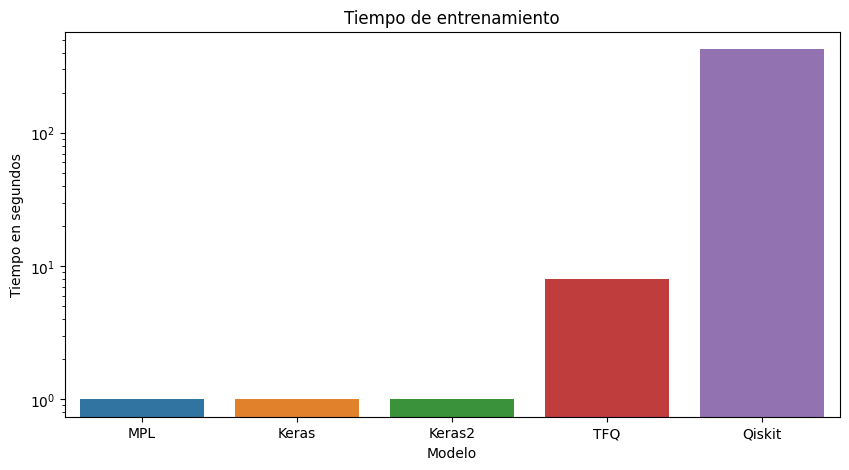

In [62]:
modelos = ["MPL", "Keras","Keras2","TFQ","Qiskit"]
counts = [resultados_mlp[2],endTestingTime_keras,endTestingTime_keras2,endTestingTime_tfq,endTestingTime_q]
fig = plt.figure(dpi=100, figsize=(10,5))
ax = fig.gca()
seaborn.barplot(x=modelos, y=counts, ax=ax, orient="v")
ax.set_ylabel("Tiempo en segundos")
ax.set_xlabel("Modelo")
ax.set_title(f"Tiempo de entrenamiento")
ax.set_yscale("log")
plt.savefig('Tiempo_testeo.png', dpi=400)
plt.show()

In [69]:
print("Tiempo testeo MLP: ", resultados_mlp[2],"segundos")
print("Tiempo testeo Keras: ", endTestingTime_keras, "segundos")
print("Tiempo testeo Keras: ", endTestingTime_keras2, "segundos")
print("Tiempo testeo Keras: ", endTestingTime_tfq, "segundos")
print("Tiempo testeo Keras: ", endTestingTime_q, "segundos")

Tiempo testeo MLP:  1.0028724670410156 segundos
Tiempo testeo Keras:  1.0022850036621094 segundos
Tiempo testeo Keras:  1.0031447410583496 segundos
Tiempo testeo Keras:  8.013876676559448 segundos
Tiempo testeo Keras:  425.1684184074402 segundos
